In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
%matplotlib inline


In [2]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2009-11-30']


In [14]:
yield_data.iloc[:,:11].astype(np.float64).mean()

1-month    0.148178
3-month    0.175870
6-month    0.247427
1-year     0.344630
2-year     0.607831
3-year     0.886202
5-year     1.465411
7-year     1.948336
10-year    2.388525
20-year    3.002925
30-year    3.303752
dtype: float64

In [3]:
np.random.seed(7)
variance = np.abs(np.random.normal(1,1,size=11))
variance

array([ 2.6905257 ,  0.53406263,  1.03282016,  1.40751628,  0.21107697,
        1.00206557,  0.99910961,  0.75472431,  2.01765801,  1.60049852,
        0.37457103])

In [4]:
yield_data_vol = yield_data.copy()
yield_data_vol.iloc[:,:11] = \
pd.concat([yield_data[col].astype(np.float64) + np.random.normal(0,var,size=yield_data.shape[0]) 
           for col,var in zip(yield_data.iloc[:,:11].columns,variance)],1)

In [5]:
yield_data.iloc[:,:11].astype(np.float64).std()

1-month    0.224211
3-month    0.248385
6-month    0.274222
1-year     0.296809
2-year     0.324495
3-year     0.379618
5-year     0.476411
7-year     0.541396
10-year    0.585950
20-year    0.694698
30-year    0.648118
dtype: float64

In [6]:
yield_data_vol.iloc[:,:11].std()

1-month    2.663237
3-month    0.582473
6-month    1.081680
1-year     1.418652
2-year     0.385847
3-year     1.044533
5-year     1.117172
7-year     0.929277
10-year    2.092859
20-year    1.765406
30-year    0.737942
dtype: float64

** Use [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to smooth the series(get rid of peaks in Monday and Friday). I use rolling window of 15 and power of 3 **

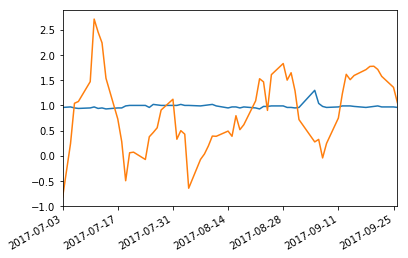

In [7]:
##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data_vol.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()
yield_data[yield_data.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered[yield_data_filtered.index >'2017-07-01']['1-month'].astype(np.float32).plot()

**Define a rolling window function that calculate following statistic for one column:**  
1.Mean  
2.Standard Deviation  
3.Median  
4.Min  
5.Max  
6.Rooted Mean Square  
7.[Crest Factor](https://en.wikipedia.org/wiki/Crest_factor)  
8.[Zero-crossing Rate](https://en.wikipedia.org/wiki/Zero-crossing_rate)(here is Mean-crossing Rate)  
9.Trend(Slope of linear regression)

In [8]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [9]:
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(10)


,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,30-year_mean_15day,30-year_std_15day,30-year_median_15day,30-year_min_15day,30-year_max_15day,30-year_mean_20day,30-year_std_20day,30-year_median_20day,30-year_min_20day,30-year_max_20day
2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** Append the actual yield values and apply lag **

In [10]:
yield_data_features=pd.concat([yield_data_features,yield_data],axis=1)
#yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()
for i in range(1,11):
    temp=yield_data_features[[col for col in yield_data_filtered.columns]].shift(i)
    temp.columns=[j+'_'+str(i) for j in list(temp.columns)]
    yield_data_features=pd.concat([yield_data_features,temp],axis=1)
yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,3-month_10,6-month_10,1-year_10,2-year_10,3-year_10,5-year_10,7-year_10,10-year_10,20-year_10,30-year_10
2010-01-14,-1.468347,0.565086,-1.222143,-2.114765,-1.068134,-1.006905,0.582885,-1.058605,-2.114765,-0.337432,...,0.05,0.19,0.45,1.08,1.65,2.61,3.34,3.8,4.54,4.61
2010-01-15,-1.730058,0.458889,-1.853267,-2.114765,-1.222143,-1.195514,0.616611,-1.068134,-2.114765,-0.337432,...,0.06,0.2,0.47,1.14,1.7,2.69,3.39,3.85,4.58,4.63
2010-01-19,-1.707015,0.497277,-1.853267,-2.114765,-1.153013,-1.312026,0.491890,-1.153013,-2.114765,-0.714254,...,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.6,4.65
2010-01-20,-1.381507,0.408623,-1.153013,-1.853267,-1.138241,-1.372596,0.427965,-1.153013,-2.114765,-1.058605,...,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2010-01-21,-0.956652,0.327398,-1.138241,-1.153013,-0.578701,-1.304038,0.516026,-1.153013,-2.114765,-0.578701,...,0.06,0.15,0.4,1.01,1.6,2.6,3.33,3.85,4.63,4.7


In [11]:
yield_data_features.shape

(1929, 343)

## Apply RF and plot 

In [12]:
def predictTargetNew(target):
    print("******predicting:",target,"*******")
    Y=yield_data_features[[target]]
    X=yield_data_features.drop(target,axis=1)
    print("Shapeof Y:",Y.shape)
    print("Shapeof X:",X.shape)
    X_train=X[X.index < '2017-07-01']
    X_test=X[X.index >= '2017-07-01']
    y_train=Y[Y.index < '2017-07-01']
    y_test=Y[Y.index  >= '2017-07-01']
    print("Shapeof Y_train:",y_train.shape)
    print("Shapeof X_train:",X_train.shape)
    print("Shapeof Y_test:",y_test.shape)
    print("Shapeof X_test:",X_test.shape)
    max_depth = 30
    regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    regr_rf.fit(X_train, y_train)
    # Predict on new data
    y_rf = pd.DataFrame(regr_rf.predict(X_test))
    y_rf.index=y_test.index
    y_rf.columns=y_test.columns
    #score
    print(target," R sq:",r2_score(y_test,y_rf))
    print(target," RMSE:",np.sqrt(mean_squared_error(y_test,y_rf)))
    final=pd.DataFrame()
    final['Time']=y_test.index
    final.index=y_test.index
    final['true']=y_test[target]
    final['pred']=y_rf[target]
    plt.figure(figsize=(8, 6))
    s = 25
    a = 0.4
    plt.figure(figsize=(8,3))
    x_axis=range(len(final))
    plt.scatter(x_axis, final['true'], edgecolor='k',
                c="navy", s=s, alpha=a, label="Data")
    plt.scatter(x_axis, final['pred'], edgecolor='k',
                c="c", s=s, alpha=a,
                label="RF (R2score={:.2f} \n RMSE={:.2f})".format(regr_rf.score(X_test, y_test),np.sqrt(mean_squared_error(y_test,y_rf))))
    plt.xticks(x_axis, final['Time'].dt.date, rotation='vertical')
    plt.xlabel("date")
    plt.ylabel(target+" yield")
    plt.gca().margins(x=0)
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

******predicting: 1-month *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1-month  R sq: -7.59375690809
1-month  RMSE: 0.140191595088


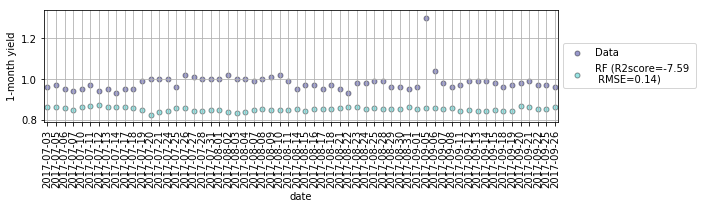

******predicting: 3-month *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3-month  R sq: -2.6319524221
3-month  RMSE: 0.0771640028338


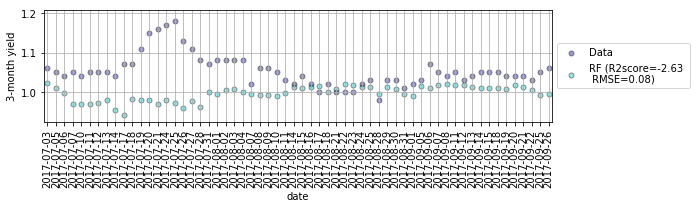

******predicting: 6-month *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


6-month  R sq: -2.29387705318
6-month  RMSE: 0.0474389080819


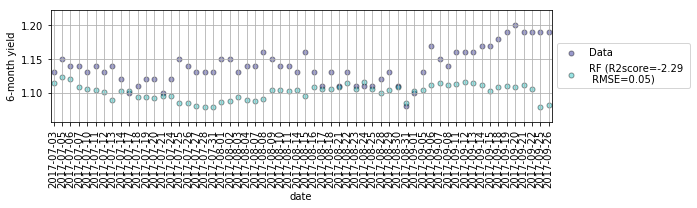

******predicting: 1-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1-year  R sq: -1.24747188386
1-year  RMSE: 0.0447653139533


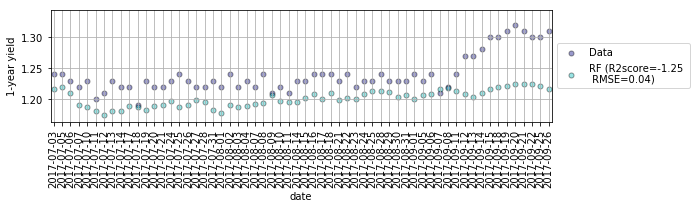

******predicting: 2-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2-year  R sq: 0.230529453697
2-year  RMSE: 0.0363221695387


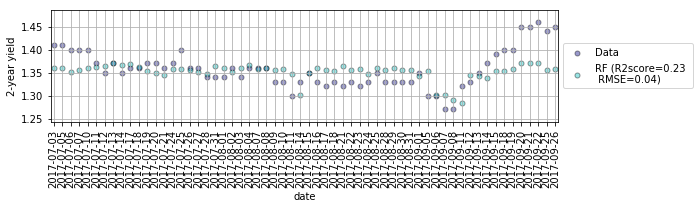

******predicting: 3-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3-year  R sq: 0.618434336392
3-year  RMSE: 0.0337661072675


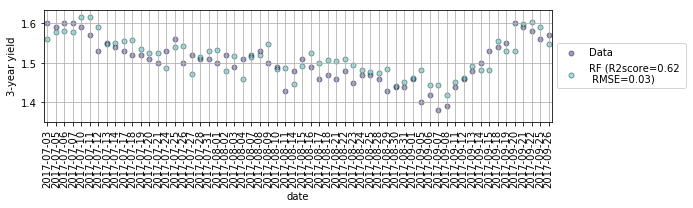

******predicting: 5-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


5-year  R sq: 0.770556192808
5-year  RMSE: 0.0352003787858


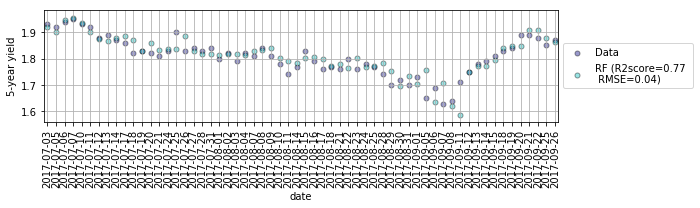

******predicting: 7-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


7-year  R sq: 0.869562773179
7-year  RMSE: 0.0278103697686


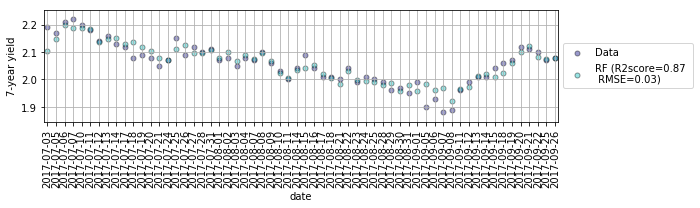

******predicting: 10-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


10-year  R sq: 0.927367748576
10-year  RMSE: 0.0213252588886


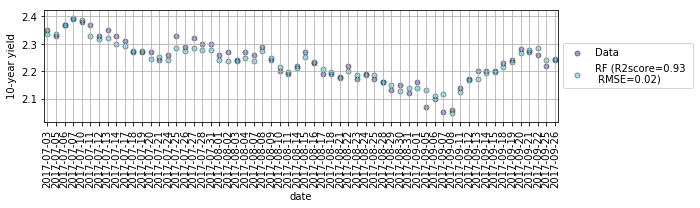

******predicting: 20-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


20-year  R sq: 0.853358590761
20-year  RMSE: 0.027861562531


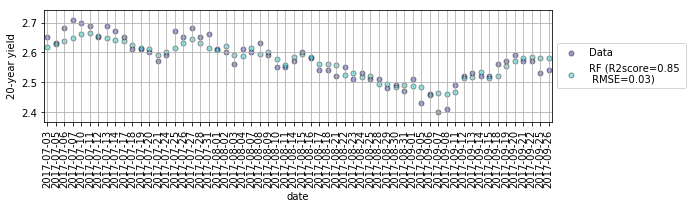

******predicting: 30-year *******
Shapeof Y: (1929, 1)
Shapeof X: (1929, 342)
Shapeof Y_train: (1869, 1)
Shapeof X_train: (1869, 342)
Shapeof Y_test: (60, 1)
Shapeof X_test: (60, 342)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


30-year  R sq: 0.6048170486
30-year  RMSE: 0.0407643635217


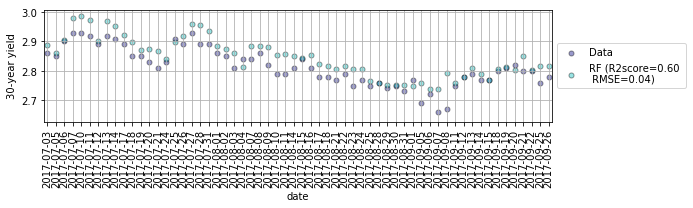

In [13]:
for target in ['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year','7-year', '10-year', '20-year', '30-year']:
    predictTargetNew(target)